# Data Transformations before Modeling Process

Note: some of preliminary methodogy for merging datasets and cleaning to set up data for training/testing is taken from https://www.kaggle.com/code/raddar/vilnius-ncaa which is a submission from the Kaggle competition the code is taken from. We will be adding other external attributes (including Pomeroy rankings and Autodraft logic) and using a different modeling process

# Importing CSV files from Kaggle

In [1125]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
os.getcwd()
os.chdir('/Users/ellawileman/Documents/spring2025/data mining/data_mining_course_project')

In [1126]:
regular_results = pd.read_csv("MRegularSeasonDetailedResults.csv")
tourney_results = pd.read_csv("MNCAATourneyDetailedResults.csv")
seeds = pd.read_csv("MNCAATourneySeeds.csv")
slots = pd.read_csv("MNCAATourneySlots.csv")
teams = pd.read_csv("MTeams.csv")

In [1127]:
display(regular_results.head())

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,...,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,...,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,...,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,...,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,...,16,17,27,21,15,12,10,7,1,14


In [1128]:
# Ensuring earliest year in datasets is 2003 (Consistent with Pomeroy Rankings)
print(min(regular_results["Season"].value_counts().index))
print(min(tourney_results["Season"].value_counts().index))
seeds = seeds.loc[seeds["Season"] >= 2003]
print(min(seeds["Season"].value_counts().index))

2003
2003
2003


In [1129]:
# how many teams in each season
teams["TeamID"].nunique()

380

In [1130]:
tourney_results

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,134,1421,92,1411,84,N,1,32,69,...,31,14,31,17,28,16,15,5,0,22
1,2003,136,1112,80,1436,51,N,0,31,66,...,16,7,7,8,26,12,17,10,3,15
2,2003,136,1113,84,1272,71,N,0,31,59,...,28,14,21,20,22,11,12,2,5,18
3,2003,136,1141,79,1166,73,N,0,29,53,...,17,12,17,14,17,20,21,6,6,21
4,2003,136,1143,76,1301,74,N,1,27,64,...,21,15,20,10,26,16,14,5,8,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1377,2024,146,1301,76,1181,64,N,0,28,60,...,20,21,26,10,27,11,9,4,5,23
1378,2024,146,1345,72,1397,66,N,0,24,53,...,26,7,11,6,17,17,6,8,4,25
1379,2024,152,1163,86,1104,72,N,0,31,62,...,23,9,11,7,21,9,7,2,5,15
1380,2024,152,1345,63,1301,50,N,0,22,55,...,19,3,4,6,22,10,11,8,3,13


For visualization purposes: can see how a team performs over the course of its regular season and its tournament for each season. 

In [1131]:
# let's take one random team and see its journey during the 2024 season
season = 2025
teamid = 1104

# showing regular season going into the tournament and tournament data for the year
r = regular_results.loc[
    (regular_results["Season"] == season)
    & ((regular_results["WTeamID"] == teamid) | (regular_results["LTeamID"] == teamid))
]
t = tourney_results.loc[
    (tourney_results["Season"] == season)
    & ((tourney_results["WTeamID"] == teamid) | (tourney_results["LTeamID"] == teamid))
]
r["win"] = np.where(r["WTeamID"] == teamid, "win", "lose")
t["win"] = np.where(t["WTeamID"] == teamid, "win", "lose")
r["type"] = "regular season"
t["type"] = "tournament"

rt = pd.concat([r, t])
rt[["DayNum", "WScore", "LScore", "type", "win"]]

/var/folders/yz/btvl331d4g54624wdzgx_2hc0000gn/T/ipykernel_68530/3446749376.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  r["win"] = np.where(r["WTeamID"] == teamid, "win", "lose")
/var/folders/yz/btvl331d4g54624wdzgx_2hc0000gn/T/ipykernel_68530/3446749376.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  r["type"] = "regular season"


,DayNum,WScore,LScore,type,win
113241,0,110,54,regular season,win
113411,4,88,79,regular season,win
113547,7,72,64,regular season,win
113724,11,87,78,regular season,lose
113916,16,100,87,regular season,win
114219,22,85,80,regular season,win
114275,23,95,90,regular season,win
114447,26,83,81,regular season,lose
114563,30,94,79,regular season,win
114859,40,83,75,regular season,win


In [1132]:
len(tourney_results[tourney_results["Season"] == 2023])
# 67 games in tournament 

67

In [1133]:
# Looking into format of "seeds" table 
seeds.reset_index(drop=True, inplace=True)
s = seeds.loc[seeds["Season"] == 2003]
[s.loc[s["Seed"].str.startswith(d)] for d in ("X", "Y", "Z", "W")]
# Note that X, Y, Z, W are the divisions and each will have its own seed. 

[    Season  Seed  TeamID
 16    2003   X01    1400
 17    2003   X02    1196
 18    2003   X03    1462
 19    2003   X04    1390
 20    2003   X05    1163
 21    2003   X06    1268
 22    2003   X07    1277
 23    2003   X08    1261
 24    2003   X09    1345
 25    2003   X10    1160
 26    2003   X11    1423
 27    2003   X12    1140
 28    2003   X13    1360
 29    2003   X14    1407
 30    2003   X15    1358
 31    2003  X16a    1411
 32    2003  X16b    1421,
     Season Seed  TeamID
 33    2003  Y01    1246
 34    2003  Y02    1338
 35    2003  Y03    1266
 36    2003  Y04    1173
 37    2003  Y05    1458
 38    2003  Y06    1281
 39    2003  Y07    1231
 40    2003  Y08    1332
 41    2003  Y09    1428
 42    2003  Y10    1104
 43    2003  Y11    1356
 44    2003  Y12    1451
 45    2003  Y13    1409
 46    2003  Y14    1221
 47    2003  Y15    1447
 48    2003  Y16    1237,
     Season Seed  TeamID
 49    2003  Z01    1112
 50    2003  Z02    1242
 51    2003  Z03    1181
 52  

# Double the dataset with swapped team positions in box scores
- Avoid bias from putting team in T1 position (on left vs. right)
- Help model generalize rather than learn teams specific position

In [1134]:
'''
# double the dataset with swapped team positions in box scores
def prepare_data(df):
    df = df[["Season", "DayNum", "LTeamID", "LScore", "WTeamID", "WScore", "NumOT",
            "LFGM", "LFGA", "LFGM3", "LFGA3", "LFTM", "LFTA", "LOR", "LDR", "LAst", "LTO", "LStl", "LBlk", "LPF",
            "WFGM", "WFGA", "WFGM3", "WFGA3", "WFTM", "WFTA", "WOR", "WDR", "WAst", "WTO", "WStl", "WBlk", "WPF"]]
    

    # adjustment factor for overtimes, as more stats are accumulated during overtimes
    adjot = (40 + 5 * df["NumOT"]) / 40
    # selecting which columns to adjust (not Season, DayNum, LTeamID, WTeamID))
    adjcols = ["LScore", "WScore", 
               "LFGM", "LFGA", "LFGM3", "LFGA3", "LFTM", "LFTA", "LOR", "LDR", "LAst", "LTO", "LStl", "LBlk", "LPF",
               "WFGM", "WFGA", "WFGM3", "WFGA3", "WFTM", "WFTA", "WOR", "WDR", "WAst", "WTO", "WStl", "WBlk", "WPF"]
    for col in adjcols:
        df[col] = df[col] / adjot    
    
    dfswap = df.copy()
    # Swapping team positions
    df.columns = [x.replace("W", "T1_").replace("L", "T2_") for x in list(df.columns)]
    dfswap.columns = [x.replace("L", "T1_").replace("W", "T2_") for x in list(dfswap.columns)]
    output = pd.concat([df, dfswap]).reset_index(drop=True)
    output["PointDiff"] = output["T1_Score"] - output["T2_Score"]
    # if positive point diff (assuming team 1 is the winner or loser we consider), then team 1 wins
    output["win"] = (output["PointDiff"] > 0) * 1
    # output["men_women"] = (output["T1_TeamID"].apply(lambda t: str(t).startswith("1"))) * 1  # 0: women, 1: men
    return output

regular_data = prepare_data(regular_results)
tourney_data = prepare_data(tourney_results)
'''

'\n# double the dataset with swapped team positions in box scores\ndef prepare_data(df):\n    df = df[["Season", "DayNum", "LTeamID", "LScore", "WTeamID", "WScore", "NumOT",\n            "LFGM", "LFGA", "LFGM3", "LFGA3", "LFTM", "LFTA", "LOR", "LDR", "LAst", "LTO", "LStl", "LBlk", "LPF",\n            "WFGM", "WFGA", "WFGM3", "WFGA3", "WFTM", "WFTA", "WOR", "WDR", "WAst", "WTO", "WStl", "WBlk", "WPF"]]\n    \n\n    # adjustment factor for overtimes, as more stats are accumulated during overtimes\n    adjot = (40 + 5 * df["NumOT"]) / 40\n    # selecting which columns to adjust (not Season, DayNum, LTeamID, WTeamID))\n    adjcols = ["LScore", "WScore", \n               "LFGM", "LFGA", "LFGM3", "LFGA3", "LFTM", "LFTA", "LOR", "LDR", "LAst", "LTO", "LStl", "LBlk", "LPF",\n               "WFGM", "WFGA", "WFGM3", "WFGA3", "WFTM", "WFTA", "WOR", "WDR", "WAst", "WTO", "WStl", "WBlk", "WPF"]\n    for col in adjcols:\n        df[col] = df[col] / adjot    \n    \n    dfswap = df.copy()\n    # Swap

In [1135]:
def prepare_data_regular(df):
    df = df[["Season", "DayNum", "LTeamID", "LScore", "WTeamID", "WScore", "NumOT",
            "LFGM", "LFGA", "LFGM3", "LFGA3", "LFTM", "LFTA", "LOR", "LDR", "LAst", "LTO", "LStl", "LBlk", "LPF",
            "WFGM", "WFGA", "WFGM3", "WFGA3", "WFTM", "WFTA", "WOR", "WDR", "WAst", "WTO", "WStl", "WBlk", "WPF"]]

    # OT adjustment factor
    adjot = (40 + 5 * df["NumOT"]) / 40
    adjcols = ["LScore", "WScore", 
               "LFGM", "LFGA", "LFGM3", "LFGA3", "LFTM", "LFTA", "LOR", "LDR", "LAst", "LTO", "LStl", "LBlk", "LPF",
               "WFGM", "WFGA", "WFGM3", "WFGA3", "WFTM", "WFTA", "WOR", "WDR", "WAst", "WTO", "WStl", "WBlk", "WPF"]
    for col in adjcols:
        df[col] = df[col] / adjot

    # Swap win/loss team columns to double dataset
    dfswap = df.copy()
    df.columns = [x.replace("W", "T1_").replace("L", "T2_") for x in df.columns]
    dfswap.columns = [x.replace("L", "T1_").replace("W", "T2_") for x in dfswap.columns]

    output = pd.concat([df, dfswap]).reset_index(drop=True)
    output["PointDiff"] = output["T1_Score"] - output["T2_Score"]
    output["win"] = (output["PointDiff"] > 0).astype(int)
    return output
regular_data = prepare_data_regular(regular_results)


/var/folders/yz/btvl331d4g54624wdzgx_2hc0000gn/T/ipykernel_68530/1021593081.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col] / adjot


Append 2025 tourney data (scraped from web) and pre 2025 tourney data

In [1136]:
# Load pre-2025 and 2025 tournament results
tourney_pre2025 = tourney_results[[
    "Season", "DayNum", "WTeamID", "WScore", "LTeamID", "LScore"
]]
tourney_2025 = pd.read_csv("2025_Tourney_Results_Complete.csv")[[
    "Season", "DayNum", "WTeamID", "WScore", "LTeamID", "LScore"
]]

# Combine into one full tournament set
combined_tourney = pd.concat([tourney_pre2025, tourney_2025], ignore_index=True)

# Rename for winner = T1, loser = T2
combined_tourney = combined_tourney.rename(columns={
    "WTeamID": "T1_TeamID",
    "WScore": "T1_Score",
    "LTeamID": "T2_TeamID",
    "LScore": "T2_Score"
})

# Compute point diff and assign win = 1 (T1 won)
combined_tourney["PointDiff"] = combined_tourney["T1_Score"] - combined_tourney["T2_Score"]
combined_tourney["win"] = 1

# Now create the swapped version: T2 is T1, T1 is T2, and win = 0
swapped = combined_tourney.rename(columns={
    "T1_TeamID": "T2_TeamID",
    "T2_TeamID": "T1_TeamID",
    "T1_Score": "T2_Score",
    "T2_Score": "T1_Score"
})
swapped["PointDiff"] = swapped["T1_Score"] - swapped["T2_Score"]
swapped["win"] = 0

# Combine original + swapped for a balanced set
tourney_data = pd.concat([combined_tourney, swapped], ignore_index=True)

# Final column order (optional)
tourney_data = tourney_data[["Season", "T1_TeamID", "T2_TeamID", "T1_Score", "T2_Score", "PointDiff", "win"]]


In [1137]:
display(regular_data.head())

,Season,DayNum,T2_TeamID,T2_Score,T1_TeamID,T1_Score,NumOT,T2_FGM,T2_FGA,T2_FGM3,...,T1_FTA,T1_OR,T1_DR,T1_Ast,T1_TO,T1_Stl,T1_Blk,T1_PF,PointDiff,win
0,2003,10,1328,62.0,1104,68.0,0,22.0,53.0,2.0,...,18.0,14.0,24.0,13.0,23.0,7.0,1.0,22.0,6.0,1
1,2003,10,1393,63.0,1272,70.0,0,24.0,67.0,6.0,...,19.0,15.0,28.0,16.0,13.0,4.0,4.0,18.0,7.0,1
2,2003,11,1437,61.0,1266,73.0,0,22.0,73.0,3.0,...,29.0,17.0,26.0,15.0,10.0,5.0,2.0,25.0,12.0,1
3,2003,11,1457,50.0,1296,56.0,0,18.0,49.0,6.0,...,31.0,6.0,19.0,11.0,12.0,14.0,2.0,18.0,6.0,1
4,2003,11,1208,71.0,1400,77.0,0,24.0,62.0,6.0,...,13.0,17.0,22.0,12.0,14.0,4.0,4.0,20.0,6.0,1


# Want tourney data for **labels** to train on

In [1138]:
massey_ordinals = pd.read_csv("PreTourneyMasseyOrdinals.csv")
# selecting only columns we want to merge in 
massey = massey_ordinals[["Season", "TeamID", "OrdinalRank"]].copy()
display(massey.head())
# we want to take the OrinalRank column and merge it with our tourney data (for each team T1 and T2 on its team id)
# means need to merge twice like shown above
massey.dtypes

,Season,TeamID,OrdinalRank
0,2003,1102,159
1,2003,1103,229
2,2003,1104,12
3,2003,1105,314
4,2003,1106,260


Season         int64
TeamID         int64
OrdinalRank    int64
dtype: object

In [1139]:
# grabbing numeric part of seed and converting to int ( we still want to keep the division info)
seeds["seed"] = seeds["Seed"].apply(lambda x: int(x[1:3]))

seeds_T1 = seeds[["Season", "TeamID", "seed"]].copy()
seeds_T2 = seeds[["Season", "TeamID", "seed"]].copy()
seeds_T1.columns = ["Season", "T1_TeamID", "T1_seed"]
seeds_T2.columns = ["Season", "T2_TeamID", "T2_seed"]

# merging seeds (for each team) with tourney data
tourney_data = tourney_data[["Season", "T1_TeamID", "T2_TeamID", "PointDiff", "win",]]
tourney_data = pd.merge(tourney_data, seeds_T1, on=["Season", "T1_TeamID"], how="left")
tourney_data = pd.merge(tourney_data, seeds_T2, on=["Season", "T2_TeamID"], how="left")
tourney_data["Seed_diff"] = tourney_data["T2_seed"] - tourney_data["T1_seed"]
# dont need individual seeds for each team if have difference
tourney_data = tourney_data[["Season", "T1_TeamID", "T2_TeamID", "PointDiff", "win", "Seed_diff"]]
display(tourney_data)

,Season,T1_TeamID,T2_TeamID,PointDiff,win,Seed_diff
0,2003,1421,1411,8,1,0.0
1,2003,1112,1436,29,1,15.0
2,2003,1113,1272,13,1,-3.0
3,2003,1141,1166,6,1,-5.0
4,2003,1143,1301,2,1,1.0
...,...,...,...,...,...,...
2887,2025,1429,1250,-11,0,NaN
2888,2025,1472,1344,-12,0,NaN
2889,2025,1131,1206,-1,0,NaN
2890,2025,1358,1106,-1,0,NaN


<Axes: xlabel='Seed_diff', ylabel='PointDiff'>

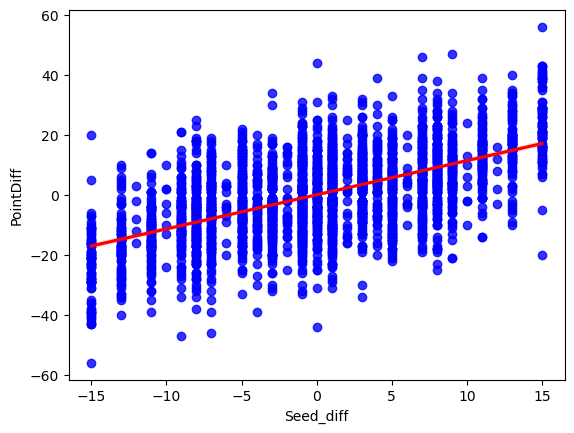

In [1140]:
# seed difference vs point difference (between Team 1 and Team 2)
sns.regplot(x=tourney_data["Seed_diff"], y=tourney_data["PointDiff"], color='blue', line_kws={"color": "red"})

# Aggregating Game Stats: Offensive/Defensive for *Each T1 and T2*

In [1141]:
# From MRegularSeasonDetailedResults and some of ourcalculations (point diff)
# box score columns, for which we want features to our model
boxcols = [
    "T1_Score", "T1_FGM", "T1_FGA", "T1_FGM3", "T1_FGA3", "T1_FTM", "T1_FTA",
    "T1_OR", "T1_DR", "T1_Ast", "T1_TO", "T1_Stl", "T1_Blk", "T1_PF",
    "T2_Score", "T2_FGM", "T2_FGA", "T2_FGM3", "T2_FGA3", "T2_FTM", "T2_FTA",
    "T2_OR", "T2_DR", "T2_Ast", "T2_TO", "T2_Stl", "T2_Blk", "T2_PF",
    "PointDiff",
]

# Regular season is **attributes** we train on

In [1142]:
# calculate season averages for each team 
# for each team, we take the mean of the box score columns (for each unique instance of team T1 and year)
ss = regular_data.groupby(["Season", "T1_TeamID"])[boxcols].agg("mean").reset_index()

ss_T1 = ss.copy()
ss_T1.columns = ["T1_avg_" + x.replace("T1_", "").replace("T2_", "opponent_") for x in list(ss_T1.columns)]
ss_T1 = ss_T1.rename({"T1_avg_Season": "Season", "T1_avg_TeamID": "T1_TeamID"}, axis=1)
ss_T2 = ss.copy()
ss_T2.columns = ["T2_avg_" + x.replace("T1_", "").replace("T2_", "opponent_") for x in list(ss_T2.columns)]
ss_T2 = ss_T2.rename({"T2_avg_Season": "Season", "T2_avg_TeamID": "T2_TeamID"}, axis=1)

# merging season averages with tourney data
tourney_data = pd.merge(tourney_data, ss_T1, on=["Season", "T1_TeamID"], how="left")
tourney_data = pd.merge(tourney_data, ss_T2, on=["Season", "T2_TeamID"], how="left")
display(tourney_data.head())

,Season,T1_TeamID,T2_TeamID,PointDiff,win,Seed_diff,T1_avg_Score,T1_avg_FGM,T1_avg_FGA,T1_avg_FGM3,...,T2_avg_opponent_FTM,T2_avg_opponent_FTA,T2_avg_opponent_OR,T2_avg_opponent_DR,T2_avg_opponent_Ast,T2_avg_opponent_TO,T2_avg_opponent_Stl,T2_avg_opponent_Blk,T2_avg_opponent_PF,T2_avg_PointDiff
0,2003,1421,1411,8,1,0.0,69.615326,23.847510,55.639847,6.348659,...,11.914815,18.655556,11.881481,22.781481,13.718519,14.259259,7.977778,2.596296,21.533333,1.948148
1,2003,1112,1436,29,1,15.0,84.511905,30.067460,65.087302,6.984127,...,10.331034,15.482759,9.517241,21.641379,13.158621,12.910345,7.082759,3.655172,17.772414,4.689655
2,2003,1113,1272,13,1,-3.0,75.344828,27.003831,56.436782,3.977011,...,13.333333,20.659004,12.295019,23.482759,13.237548,15.019157,7.252874,3.153257,19.827586,8.693487
3,2003,1141,1166,6,1,-5.0,79.344828,26.620690,52.689655,6.827586,...,11.643098,16.619529,11.020202,21.289562,12.329966,17.006734,6.306397,2.569024,19.323232,14.898990
4,2003,1143,1301,2,1,1.0,73.636015,27.015326,57.946360,6.314176,...,15.374074,21.129630,10.514815,21.348148,12.511111,14.581481,7.418519,2.811111,19.262963,4.370370


In [1143]:
tourney_data.columns

Index(['Season', 'T1_TeamID', 'T2_TeamID', 'PointDiff', 'win', 'Seed_diff',
       'T1_avg_Score', 'T1_avg_FGM', 'T1_avg_FGA', 'T1_avg_FGM3',
       'T1_avg_FGA3', 'T1_avg_FTM', 'T1_avg_FTA', 'T1_avg_OR', 'T1_avg_DR',
       'T1_avg_Ast', 'T1_avg_TO', 'T1_avg_Stl', 'T1_avg_Blk', 'T1_avg_PF',
       'T1_avg_opponent_Score', 'T1_avg_opponent_FGM', 'T1_avg_opponent_FGA',
       'T1_avg_opponent_FGM3', 'T1_avg_opponent_FGA3', 'T1_avg_opponent_FTM',
       'T1_avg_opponent_FTA', 'T1_avg_opponent_OR', 'T1_avg_opponent_DR',
       'T1_avg_opponent_Ast', 'T1_avg_opponent_TO', 'T1_avg_opponent_Stl',
       'T1_avg_opponent_Blk', 'T1_avg_opponent_PF', 'T1_avg_PointDiff',
       'T2_avg_Score', 'T2_avg_FGM', 'T2_avg_FGA', 'T2_avg_FGM3',
       'T2_avg_FGA3', 'T2_avg_FTM', 'T2_avg_FTA', 'T2_avg_OR', 'T2_avg_DR',
       'T2_avg_Ast', 'T2_avg_TO', 'T2_avg_Stl', 'T2_avg_Blk', 'T2_avg_PF',
       'T2_avg_opponent_Score', 'T2_avg_opponent_FGM', 'T2_avg_opponent_FGA',
       'T2_avg_opponent_FGM3', 'T2_

Basically, tourney schedule is deciding WHICH matchups we use in training set (and who won!), seeds, and point differences.
For each team in the match up, we are going to include its season averages in play statistics IN this row. This way, we are training on during-season data to see if we can predict tournament matchup results (our bracket)

# Questions: 
- Should we be subtracting or taking ratios between T1 and T2 stats so we can get relative stats? 
- Do we want ALL of these during game stats or do we just want certain ones? We can start with all and use some systematic feature selection because we don't have too much field knowledge

Note: to add: massey ordinals rankings (diff?), pomeroy ratings (diff?), conference 

Need to choose ranking or few from all possible Massey Ranking Systems

In [1144]:
pre_tourney_massey = pd.read_csv("Massey_AllYears.csv")
# selecting only columns we want to merge in 
#massey = massey_ordinals[["Season", "TeamID", "OrdinalRank"]].copy()
#display(massey_ordinals.head())
# we want to take the OrinalRank column and merge it with our tourney data (for each team T1 and T2 on its team id)
# means need to merge twice like shown above
#pre_tourney_massey = massey_ordinals[massey_ordinals["RankingDayNum"] == 133]
display(pre_tourney_massey.head())
pre_tourney_massey["SystemName"].value_counts()
# would only choose ranking system where we have all teams pre tournament (day 133) rankings for each year
# or at least as many as possible (dont mind cutting a few teams that wouldn't be ranked and therefore not in the tournament)

,Season,RankingDayNum,SystemName,TeamID,OrdinalRank
0,2003,133,AP,1112,2
1,2003,133,AP,1163,23
2,2003,133,AP,1166,15
3,2003,133,AP,1173,16
4,2003,133,AP,1181,7


SystemName
MOR    7263
POM    7260
WLK    7260
DOL    7259
COL    7258
       ... 
REI     326
RM      326
JON     326
D1A     200
TRX     120
Name: count, Length: 180, dtype: int64

From source: https://kenpom.com (also includes meaning for each field)

Compared to our original 80 teams:

In [1145]:
# Group by 'systemName' and count distinct teams in 'TeamID' (or the relevant column for teams)
distinct_teams_per_system = pre_tourney_massey.groupby('SystemName')['TeamID'].nunique().sort_values(ascending=False)

print(distinct_teams_per_system[distinct_teams_per_system == 369])

# comparing to abbreviation mappings on Massey site:
# can't find DOL, DUN, SEL, WLK, POM
# Use RPI, COL (Colley), MOR (Moore), BIH (Bihl), MAS bc have mappings to name/meaning
# already have pomeroy 

# creating least amount of missing values after merges/joins by selecting the system with most teams
# less imputation or dropped values needed. generating complete-case training instances 


SystemName
DOL    369
DUN    369
RPI    369
COL    369
SEL    369
MOR    369
BIH    369
POM    369
MAS    369
WLK    369
Name: TeamID, dtype: int64


In [1146]:
# Filtering for only these ranking systems 
# "RPI", "MOR", "COL", "BIH", "MAS"
pre_tourney_massey = pre_tourney_massey.loc[(pre_tourney_massey["SystemName"] == "RPI") | (pre_tourney_massey["SystemName"] == "MOR") | (pre_tourney_massey["SystemName"] == "COL") | (pre_tourney_massey["SystemName"] == "BIH") | (pre_tourney_massey["SystemName"] == "MAS")]
display(pre_tourney_massey.head())

# Now that we only have 5 ranking systems, convert system name to columns 
# pivot the data to have systemName as columns
pivoted_massey = pre_tourney_massey.pivot(index=['TeamID', 'Season'], columns='SystemName', values='OrdinalRank').reset_index()
print(pivoted_massey)

,Season,RankingDayNum,SystemName,TeamID,OrdinalRank
352,2003,133,BIH,1102,172
353,2003,133,BIH,1103,177
354,2003,133,BIH,1104,40
355,2003,133,BIH,1105,312
356,2003,133,BIH,1106,269


SystemName  TeamID  Season    BIH    COL    MAS    MOR    RPI
0             1101    2014  346.0  340.0  349.0  349.0    NaN
1             1101    2015  325.0  322.0  331.0  346.0  325.0
2             1101    2016  309.0  304.0  312.0  311.0  321.0
3             1101    2017  285.0  287.0  292.0  317.0  289.0
4             1101    2018  260.0  267.0  259.0  265.0  260.0
...            ...     ...    ...    ...    ...    ...    ...
7258          1476    2023  312.0  301.0  327.0  327.0  263.0
7259          1476    2024  358.0  360.0  359.0  356.0  360.0
7260          1477    2023  311.0  315.0  326.0  308.0  308.0
7261          1477    2024  318.0  312.0  325.0  331.0  310.0
7262          1478    2024  311.0  316.0  322.0  281.0  303.0

[7263 rows x 7 columns]


In [1147]:
#test = pd.merge(tourney_data, massey, left_on=["Season", "T2_TeamID"], right_on=["Season", "TeamID"], how="left")

In [1148]:
# We will be combining in this data from Pomeroy rankings (external source)
pomeroy = pd.read_csv("KenPom Stats.csv")
pomeroy = pomeroy.dropna()
pomeroy = pomeroy.drop(columns=[col for col in pomeroy.columns if "_rank" in col])
pomeroy["YEAR"] = pomeroy["YEAR"].astype(int)
# remove periods from team name column 
pomeroy['Team'] = pomeroy['Team'].str.replace('.', '', regex=False)
dat= pd.merge(pomeroy, teams[["TeamID", "TeamName"]], how='inner',left_on="Team", right_on="TeamName")
dat = dat.drop(columns=dat.columns[-1])

print(pomeroy["Team"].nunique())
print(dat["Team"].nunique())
display(dat)

# for this file we can use the ranking for each stat (its built in) and maybe use some differences
# because we also have the raw value for these statistics, idk which we would want

# mapping to this table's year and Team id (team id to team name table)

/var/folders/yz/btvl331d4g54624wdzgx_2hc0000gn/T/ipykernel_68530/1074537758.py:2: DtypeWarning: Columns (1,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  pomeroy = pd.read_csv("KenPom Stats.csv")


395
290


,Rk,Team,Conf,W_L,NetRtg,ORtg,DRtg,AdjT,Luck,SchedStrengthNetRtg,SchedStrengthORtg,SchedStrengthDRtg,NCSOSNetRtg,YEAR,TeamID
0,1.0,Kentucky,SEC,32-4,29.18,116.5,87.4,67.7,0.051,11.20,108.6,97.4,6.77,2003,1246
1,2.0,Kansas,B12,30-8,28.62,115.0,86.4,72.2,-0.017,11.84,108.6,96.8,6.07,2003,1242
2,3.0,Pittsburgh,BE,28-5,28.61,114.8,86.2,64.7,-0.023,7.08,105.5,98.4,-8.24,2003,1338
3,4.0,Arizona,P10,28-4,26.80,115.6,88.8,72.7,-0.007,8.69,107.2,98.5,8.19,2003,1112
4,5.0,Illinois,B10,25-7,24.47,113.2,88.7,67.8,-0.029,7.29,105.8,98.5,-4.18,2003,1228
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6217,356.0,New Hampshire,AE,24-Aug,-21.72,93.9,115.6,67.6,0.019,-6.16,103.7,109.9,-3.50,2025,1306
6218,359.0,Canisius,MAAC,28-Mar,-23.01,99.1,122.1,66.4,-0.078,-4.88,103.0,107.9,3.86,2025,1145
6219,360.0,Alabama A&M,SWAC,22-Oct,-23.36,92.2,115.6,71.2,-0.022,-9.57,101.3,110.8,1.93,2025,1105
6220,361.0,Coppin St,MEAC,24-Jun,-24.40,87.4,111.8,68.0,0.033,-4.43,105.3,109.8,4.14,2025,1164


Note that with using pomeroy data we are gonna be reducing the number of teams, but these teams not considered likely won't be tournament games we care about. We can make that call

To do list

In [1149]:
# add in the massey ordinals - NEED TO CHOOSE SYSTEM
# add in pomeroy rankings (delete all columns with rank because are showing what rank that team would be in terms of that stat)
# take all differences T1 - T2 for each stat
# can keep the point differences and win/loss columns (we can decide later when fitting models if we want numeric or binary label)
# export to csv 
# bring into weka - start looking at correlations of our final dataset 

In [1150]:
# Merge pomeroy ORtg and DRtg for T1
tourney_data = tourney_data.merge(
    dat[['TeamID', 'YEAR', 'ORtg', 'DRtg']],
    how='left', 
    left_on=['T1_TeamID', 'Season'],
    right_on=['TeamID', 'YEAR']
).rename(columns={
    'ORtg': 'T1_ORtg',
    'DRtg': 'T1_Drtg'
}).drop(columns=['TeamID', 'YEAR'])

tourney_data

,Season,T1_TeamID,T2_TeamID,PointDiff,win,Seed_diff,T1_avg_Score,T1_avg_FGM,T1_avg_FGA,T1_avg_FGM3,...,T2_avg_opponent_OR,T2_avg_opponent_DR,T2_avg_opponent_Ast,T2_avg_opponent_TO,T2_avg_opponent_Stl,T2_avg_opponent_Blk,T2_avg_opponent_PF,T2_avg_PointDiff,T1_ORtg,T1_Drtg
0,2003,1421,1411,8,1,0.0,69.615326,23.847510,55.639847,6.348659,...,11.881481,22.781481,13.718519,14.259259,7.977778,2.596296,21.533333,1.948148,101.2,113.5
1,2003,1112,1436,29,1,15.0,84.511905,30.067460,65.087302,6.984127,...,9.517241,21.641379,13.158621,12.910345,7.082759,3.655172,17.772414,4.689655,115.6,88.8
2,2003,1113,1272,13,1,-3.0,75.344828,27.003831,56.436782,3.977011,...,12.295019,23.482759,13.237548,15.019157,7.252874,3.153257,19.827586,8.693487,113.9,97.4
3,2003,1141,1166,6,1,-5.0,79.344828,26.620690,52.689655,6.827586,...,11.020202,21.289562,12.329966,17.006734,6.306397,2.569024,19.323232,14.898990,NaN,NaN
4,2003,1143,1301,2,1,1.0,73.636015,27.015326,57.946360,6.314176,...,10.514815,21.348148,12.511111,14.581481,7.418519,2.811111,19.262963,4.370370,109.9,96.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2887,2025,1429,1250,-11,0,NaN,79.750000,27.906250,57.625000,8.718750,...,8.186508,24.535714,12.384921,10.075397,6.123016,2.865079,16.757937,-3.567460,119.8,105.8
2888,2025,1472,1344,-12,0,NaN,81.297491,27.967742,57.225806,10.261649,...,8.194444,21.381944,12.440972,8.715278,7.295139,2.892361,14.927083,-1.180556,NaN,NaN
2889,2025,1131,1206,-1,0,NaN,64.453763,23.089606,53.434409,7.373477,...,9.162963,19.670034,11.204040,11.397306,7.152862,3.311111,18.340741,6.449158,NaN,NaN
2890,2025,1358,1106,-1,0,NaN,72.118774,24.501916,56.076628,8.272031,...,9.104377,26.713805,12.447811,12.013468,5.228956,3.265993,16.057239,-0.336700,110.4,111.5


In [1151]:
#tourney_data = tourney_data.iloc[:, :-8]
tourney_data

,Season,T1_TeamID,T2_TeamID,PointDiff,win,Seed_diff,T1_avg_Score,T1_avg_FGM,T1_avg_FGA,T1_avg_FGM3,...,T2_avg_opponent_OR,T2_avg_opponent_DR,T2_avg_opponent_Ast,T2_avg_opponent_TO,T2_avg_opponent_Stl,T2_avg_opponent_Blk,T2_avg_opponent_PF,T2_avg_PointDiff,T1_ORtg,T1_Drtg
0,2003,1421,1411,8,1,0.0,69.615326,23.847510,55.639847,6.348659,...,11.881481,22.781481,13.718519,14.259259,7.977778,2.596296,21.533333,1.948148,101.2,113.5
1,2003,1112,1436,29,1,15.0,84.511905,30.067460,65.087302,6.984127,...,9.517241,21.641379,13.158621,12.910345,7.082759,3.655172,17.772414,4.689655,115.6,88.8
2,2003,1113,1272,13,1,-3.0,75.344828,27.003831,56.436782,3.977011,...,12.295019,23.482759,13.237548,15.019157,7.252874,3.153257,19.827586,8.693487,113.9,97.4
3,2003,1141,1166,6,1,-5.0,79.344828,26.620690,52.689655,6.827586,...,11.020202,21.289562,12.329966,17.006734,6.306397,2.569024,19.323232,14.898990,NaN,NaN
4,2003,1143,1301,2,1,1.0,73.636015,27.015326,57.946360,6.314176,...,10.514815,21.348148,12.511111,14.581481,7.418519,2.811111,19.262963,4.370370,109.9,96.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2887,2025,1429,1250,-11,0,NaN,79.750000,27.906250,57.625000,8.718750,...,8.186508,24.535714,12.384921,10.075397,6.123016,2.865079,16.757937,-3.567460,119.8,105.8
2888,2025,1472,1344,-12,0,NaN,81.297491,27.967742,57.225806,10.261649,...,8.194444,21.381944,12.440972,8.715278,7.295139,2.892361,14.927083,-1.180556,NaN,NaN
2889,2025,1131,1206,-1,0,NaN,64.453763,23.089606,53.434409,7.373477,...,9.162963,19.670034,11.204040,11.397306,7.152862,3.311111,18.340741,6.449158,NaN,NaN
2890,2025,1358,1106,-1,0,NaN,72.118774,24.501916,56.076628,8.272031,...,9.104377,26.713805,12.447811,12.013468,5.228956,3.265993,16.057239,-0.336700,110.4,111.5


In [1152]:
# Merge pomeroy ORtg and DRtg for T2
tourney_data = tourney_data.merge(
    dat[['TeamID', 'YEAR', 'ORtg', 'DRtg']],
    how='left', 
    left_on=['T2_TeamID', 'Season'],
    right_on=['TeamID', 'YEAR']
).rename(columns={
    'ORtg': 'T2_ORtg',
    'DRtg': 'T2_Drtg'
}).drop(columns=['TeamID', 'YEAR'])

tourney_data

,Season,T1_TeamID,T2_TeamID,PointDiff,win,Seed_diff,T1_avg_Score,T1_avg_FGM,T1_avg_FGA,T1_avg_FGM3,...,T2_avg_opponent_Ast,T2_avg_opponent_TO,T2_avg_opponent_Stl,T2_avg_opponent_Blk,T2_avg_opponent_PF,T2_avg_PointDiff,T1_ORtg,T1_Drtg,T2_ORtg,T2_Drtg
0,2003,1421,1411,8,1,0.0,69.615326,23.847510,55.639847,6.348659,...,13.718519,14.259259,7.977778,2.596296,21.533333,1.948148,101.2,113.5,NaN,NaN
1,2003,1112,1436,29,1,15.0,84.511905,30.067460,65.087302,6.984127,...,13.158621,12.910345,7.082759,3.655172,17.772414,4.689655,115.6,88.8,101.1,99.5
2,2003,1113,1272,13,1,-3.0,75.344828,27.003831,56.436782,3.977011,...,13.237548,15.019157,7.252874,3.153257,19.827586,8.693487,113.9,97.4,110.9,94.1
3,2003,1141,1166,6,1,-5.0,79.344828,26.620690,52.689655,6.827586,...,12.329966,17.006734,6.306397,2.569024,19.323232,14.898990,NaN,NaN,112.4,94.9
4,2003,1143,1301,2,1,1.0,73.636015,27.015326,57.946360,6.314176,...,12.511111,14.581481,7.418519,2.811111,19.262963,4.370370,109.9,96.3,111.2,98.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2887,2025,1429,1250,-11,0,NaN,79.750000,27.906250,57.625000,8.718750,...,12.384921,10.075397,6.123016,2.865079,16.757937,-3.567460,119.8,105.8,100.7,111.0
2888,2025,1472,1344,-12,0,NaN,81.297491,27.967742,57.225806,10.261649,...,12.440972,8.715278,7.295139,2.892361,14.927083,-1.180556,NaN,NaN,112.1,105.2
2889,2025,1131,1206,-1,0,NaN,64.453763,23.089606,53.434409,7.373477,...,11.204040,11.397306,7.152862,3.311111,18.340741,6.449158,NaN,NaN,106.2,96.8
2890,2025,1358,1106,-1,0,NaN,72.118774,24.501916,56.076628,8.272031,...,12.447811,12.013468,5.228956,3.265993,16.057239,-0.336700,110.4,111.5,101.5,110.4


In [1153]:
# Merge massey ordinals for T1 (using selected 3 ranking systems explained above)
tourney_data = tourney_data.merge(
    pivoted_massey[['TeamID', 'Season', "RPI", "MOR", "COL", "BIH", "MAS"]],
    how='left', 
    left_on=['T1_TeamID', 'Season'],
    right_on=['TeamID', 'Season']
).rename(columns={
    'RPI': 'T1_RPI',
    'MOR': 'T1_MOR',
    'COL': 'T1_COL',
    'BIH': 'T1_BIH',
    'MAS': 'T1_MAS'
}).drop(columns=['TeamID'])
tourney_data

,Season,T1_TeamID,T2_TeamID,PointDiff,win,Seed_diff,T1_avg_Score,T1_avg_FGM,T1_avg_FGA,T1_avg_FGM3,...,T2_avg_PointDiff,T1_ORtg,T1_Drtg,T2_ORtg,T2_Drtg,T1_RPI,T1_MOR,T1_COL,T1_BIH,T1_MAS
0,2003,1421,1411,8,1,0.0,69.615326,23.847510,55.639847,6.348659,...,1.948148,101.2,113.5,NaN,NaN,186.0,277.0,213.0,247.0,265.0
1,2003,1112,1436,29,1,15.0,84.511905,30.067460,65.087302,6.984127,...,4.689655,115.6,88.8,101.1,99.5,2.0,4.0,2.0,2.0,3.0
2,2003,1113,1272,13,1,-3.0,75.344828,27.003831,56.436782,3.977011,...,8.693487,113.9,97.4,110.9,94.1,32.0,22.0,38.0,43.0,40.0
3,2003,1141,1166,6,1,-5.0,79.344828,26.620690,52.689655,6.827586,...,14.898990,NaN,NaN,112.4,94.9,44.0,50.0,35.0,38.0,36.0
4,2003,1143,1301,2,1,1.0,73.636015,27.015326,57.946360,6.314176,...,4.370370,109.9,96.3,111.2,98.1,33.0,43.0,28.0,26.0,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2887,2025,1429,1250,-11,0,NaN,79.750000,27.906250,57.625000,8.718750,...,-3.567460,119.8,105.8,100.7,111.0,NaN,NaN,NaN,NaN,NaN
2888,2025,1472,1344,-12,0,NaN,81.297491,27.967742,57.225806,10.261649,...,-1.180556,NaN,NaN,112.1,105.2,NaN,NaN,NaN,NaN,NaN
2889,2025,1131,1206,-1,0,NaN,64.453763,23.089606,53.434409,7.373477,...,6.449158,NaN,NaN,106.2,96.8,NaN,NaN,NaN,NaN,NaN
2890,2025,1358,1106,-1,0,NaN,72.118774,24.501916,56.076628,8.272031,...,-0.336700,110.4,111.5,101.5,110.4,NaN,NaN,NaN,NaN,NaN


In [1154]:
# Merge massey ordinals for T1 (using selected 5 ranking systems explained above)
tourney_data = tourney_data.merge(
    pivoted_massey[['TeamID', 'Season', "RPI", "MOR", "COL", "BIH", "MAS"]],
    how='left', 
    left_on=['T2_TeamID', 'Season'],
    right_on=['TeamID', 'Season']
).rename(columns={
    'RPI': 'T2_RPI',
    'MOR': 'T2_MOR',
    'COL': 'T2_COL',
    'BIH': 'T2_BIH',
    'MAS': 'T2_MAS'
}).drop(columns=['TeamID'])
tourney_data

,Season,T1_TeamID,T2_TeamID,PointDiff,win,Seed_diff,T1_avg_Score,T1_avg_FGM,T1_avg_FGA,T1_avg_FGM3,...,T1_RPI,T1_MOR,T1_COL,T1_BIH,T1_MAS,T2_RPI,T2_MOR,T2_COL,T2_BIH,T2_MAS
0,2003,1421,1411,8,1,0.0,69.615326,23.847510,55.639847,6.348659,...,186.0,277.0,213.0,247.0,265.0,217.0,293.0,212.0,234.0,249.0
1,2003,1112,1436,29,1,15.0,84.511905,30.067460,65.087302,6.984127,...,2.0,4.0,2.0,2.0,3.0,144.0,187.0,144.0,151.0,148.0
2,2003,1113,1272,13,1,-3.0,75.344828,27.003831,56.436782,3.977011,...,32.0,22.0,38.0,43.0,40.0,26.0,23.0,19.0,19.0,18.0
3,2003,1141,1166,6,1,-5.0,79.344828,26.620690,52.689655,6.827586,...,44.0,50.0,35.0,38.0,36.0,23.0,33.0,18.0,17.0,19.0
4,2003,1143,1301,2,1,1.0,73.636015,27.015326,57.946360,6.314176,...,33.0,43.0,28.0,26.0,30.0,53.0,31.0,56.0,49.0,48.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2887,2025,1429,1250,-11,0,NaN,79.750000,27.906250,57.625000,8.718750,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2888,2025,1472,1344,-12,0,NaN,81.297491,27.967742,57.225806,10.261649,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2889,2025,1131,1206,-1,0,NaN,64.453763,23.089606,53.434409,7.373477,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2890,2025,1358,1106,-1,0,NaN,72.118774,24.501916,56.076628,8.272031,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Do subtractions between T1 and T2 numeric columns (so we are training models on the difference)

In [1155]:
# Identify all T1_ and T2_ columns
t1_columns = [col for col in tourney_data.columns if col.startswith('T1_') and col != 'T1_TeamID']
t2_columns = [col for col in tourney_data.columns if col.startswith('T2_') and col != 'T2_TeamID']

# Ensure matching columns between T1_ and T2_
common_columns = set(col[3:] for col in t1_columns).intersection(col[3:] for col in t2_columns)

# Subtract T2_ columns from T1_ columns
for col in common_columns:
    tourney_data[f'Diff_{col}'] = tourney_data[f'T1_{col}'] - tourney_data[f'T2_{col}']

tourney_data.drop(columns=t1_columns + t2_columns, inplace=True)

# Final dataset after transformations

In [1156]:
display(tourney_data.head())

,Season,T1_TeamID,T2_TeamID,PointDiff,win,Seed_diff,Diff_Drtg,Diff_avg_FTA,Diff_avg_OR,Diff_RPI,...,Diff_avg_opponent_FGM3,Diff_MAS,Diff_avg_TO,Diff_avg_opponent_PF,Diff_avg_Ast,Diff_avg_Stl,Diff_avg_PointDiff,Diff_avg_FGA,Diff_avg_opponent_Stl,Diff_avg_opponent_DR
0,2003,1421,1411,8,1,0.0,NaN,-7.501277,-1.092209,-31.0,...,-0.048404,16.0,0.764368,-3.268199,-1.400511,0.520562,-9.280715,0.587995,0.701916,-0.379949
1,2003,1112,1436,29,1,15.0,-10.7,5.434182,2.148139,-142.0,...,-0.780515,-145.0,0.673563,4.116475,3.391544,1.555446,10.290504,9.659715,-1.177997,1.426081
2,2003,1113,1272,13,1,-3.0,3.3,3.111111,-0.517241,6.0,...,-0.455939,22.0,0.141762,2.796935,-1.107280,-2.199234,-1.923372,-3.325670,-1.302682,-3.114943
3,2003,1141,1166,6,1,-5.0,NaN,5.219552,-0.262278,21.0,...,0.096830,17.0,4.931615,2.366423,-1.163822,-1.266922,-8.795542,-4.599907,2.141879,-2.393011
4,2003,1143,1301,2,1,1.0,-1.8,-1.013538,1.414943,-20.0,...,1.330779,-18.0,-0.110473,-0.343423,1.201277,-1.281098,0.342273,4.816731,-1.552618,1.310856


In [1157]:
tourney_data.columns

Index(['Season', 'T1_TeamID', 'T2_TeamID', 'PointDiff', 'win', 'Seed_diff',
       'Diff_Drtg', 'Diff_avg_FTA', 'Diff_avg_OR', 'Diff_RPI', 'Diff_BIH',
       'Diff_avg_opponent_TO', 'Diff_avg_opponent_FTA', 'Diff_avg_FTM',
       'Diff_avg_opponent_FGA3', 'Diff_MOR', 'Diff_avg_opponent_FGA',
       'Diff_avg_opponent_Score', 'Diff_avg_PF', 'Diff_avg_opponent_OR',
       'Diff_avg_FGM3', 'Diff_avg_Score', 'Diff_avg_opponent_FGM',
       'Diff_avg_opponent_Blk', 'Diff_ORtg', 'Diff_avg_Blk', 'Diff_avg_FGA3',
       'Diff_avg_opponent_FTM', 'Diff_avg_DR', 'Diff_avg_opponent_Ast',
       'Diff_avg_FGM', 'Diff_COL', 'Diff_avg_opponent_FGM3', 'Diff_MAS',
       'Diff_avg_TO', 'Diff_avg_opponent_PF', 'Diff_avg_Ast', 'Diff_avg_Stl',
       'Diff_avg_PointDiff', 'Diff_avg_FGA', 'Diff_avg_opponent_Stl',
       'Diff_avg_opponent_DR'],
      dtype='object')

In [1158]:
import matplotlib.pyplot as plt
import seaborn as sns

numeric_df = tourney_data.select_dtypes(include=['number'])
corr_matrix = numeric_df.corr()

# Unstack the correlation matrix to get pairs of attributes
correlation_pairs = corr_matrix.unstack()

# Remove self-correlations (correlation of a variable with itself)
correlation_pairs = correlation_pairs[correlation_pairs.index.get_level_values(0) != correlation_pairs.index.get_level_values(1)]

# Sort the correlation pairs by absolute value in descending order
sorted_correlations = correlation_pairs.abs().sort_values(ascending=False)

# Display the top N most highly correlated pairs
top_n = 10  # Change this to the number of pairs you want to see
print(sorted_correlations.head(top_n))

Diff_BIH               Diff_COL                 0.991440
Diff_COL               Diff_BIH                 0.991440
Diff_RPI               Diff_COL                 0.979437
Diff_COL               Diff_RPI                 0.979437
Diff_avg_opponent_FTA  Diff_avg_opponent_FTM    0.977200
Diff_avg_opponent_FTM  Diff_avg_opponent_FTA    0.977200
Diff_MAS               Diff_BIH                 0.975346
Diff_BIH               Diff_MAS                 0.975346
                       Diff_RPI                 0.969695
Diff_RPI               Diff_BIH                 0.969695
dtype: float64


From looking at top 10 correlations, we can see that the Massey ranking systems strongly agree with one another (6 of top 10 most strongly correlated pairs)

(array([ 8.,  6.,  6.,  2., 12.,  4., 10.,  4.,  6.,  8., 10., 10.,  6.,
         8.,  4.,  6.,  2.,  0.,  4.,  0.,  2.,  0.,  8., 10.,  2., 10.,
         4.,  4.,  4.,  8.]),
 array([0.50619389, 0.52236877, 0.53854365, 0.55471853, 0.57089342,
        0.5870683 , 0.60324318, 0.61941806, 0.63559294, 0.65176782,
        0.6679427 , 0.68411758, 0.70029246, 0.71646734, 0.73264223,
        0.74881711, 0.76499199, 0.78116687, 0.79734175, 0.81351663,
        0.82969151, 0.84586639, 0.86204127, 0.87821616, 0.89439104,
        0.91056592, 0.9267408 , 0.94291568, 0.95909056, 0.97526544,
        0.99144032]),
 <BarContainer object of 30 artists>)

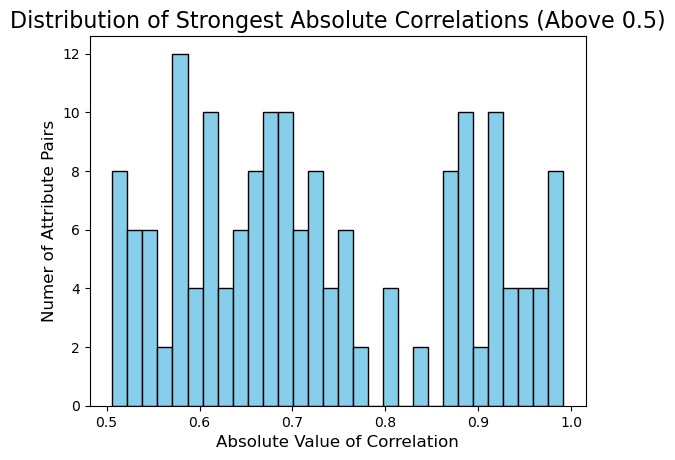

In [1159]:
plt.title("Distribution of Strongest Absolute Correlations (Above 0.5)", fontsize=16)
plt.xlabel("Absolute Value of Correlation", fontsize=12)
plt.ylabel("Numer of Attribute Pairs", fontsize=12)
filtered_correlations = correlation_pairs.abs()[correlation_pairs.abs() > 0.5]
plt.hist(filtered_correlations, bins=30, color='skyblue', edgecolor='black')

In [1160]:
# How many "strong" correlations (greater than 0.7) are there?
high_correlations = correlation_pairs[correlation_pairs.abs() > 0.7]
high_correlations = high_correlations.sort_values(ascending=False)
print(len(high_correlations))


82


There is multicollinearity in the data, which means we should not assume independence of variables in our models

# Optimal Feature Selection 
## (Note: we have 2 labels: point difference (numeric) and Win (binary))

We have to be careful with years and not use future data to predict past data. We can use "Season" column to generate these training/testing sets but we should not use it or the team IDs as an attribute.

In [1161]:
# Example: Use all years before 2023 to train, and 2023-2024 as test
train = tourney_data[tourney_data['Season'] < 2024].dropna()  # Training data (before 2024)
validation = tourney_data[tourney_data['Season'] == 2024].dropna()  # Validation data (2024)
test = tourney_data[tourney_data['Season'] == 2025]  # Test data (2025)

# removing unique columns like ID and year now that we've filtered on year
# also remove PointDiff because is our continuous target we are not using right now

# training sets
X_train = train.drop(columns=['PointDiff', 'win', 'Season', 'T1_TeamID', 'T2_TeamID'])  # or whatever your label column is
y_train = train['win']
#validation sets 
X_val = validation.drop(columns=['PointDiff', 'win', 'Season', 'T1_TeamID', 'T2_TeamID'])  # or whatever your label column is
y_val = validation['win']
# test sets
X_test = test.drop(columns=['PointDiff', 'win', 'Season', 'T1_TeamID', 'T2_TeamID'])
y_test = test['win']

In [1162]:
print(test.shape)
print(validation.shape)

(128, 42)
(118, 42)


In [1163]:
display(test.head())

,Season,T1_TeamID,T2_TeamID,PointDiff,win,Seed_diff,Diff_Drtg,Diff_avg_FTA,Diff_avg_OR,Diff_RPI,...,Diff_avg_opponent_FGM3,Diff_MAS,Diff_avg_TO,Diff_avg_opponent_PF,Diff_avg_Ast,Diff_avg_Stl,Diff_avg_PointDiff,Diff_avg_FGA,Diff_avg_opponent_Stl,Diff_avg_opponent_DR
1382,2025,1196,1436,23,1,NaN,-13.1,4.788425,4.898482,NaN,...,-0.358634,NaN,0.264706,2.185009,4.594877,2.638520,16.628083,10.061670,0.135674,-2.583491
1383,2025,1222,1255,26,1,NaN,-22.6,-9.495042,0.965269,NaN,...,-1.058125,NaN,-3.920667,-4.981677,-1.061573,0.536060,15.315619,1.257764,-2.489272,-2.769056
1384,2025,1120,1159,4,1,NaN,-20.6,7.791625,3.592382,NaN,...,-2.825084,NaN,-1.814962,4.304061,2.510290,0.593245,15.549158,4.499663,-0.690362,-2.874874
1385,2025,1242,1463,7,1,6.0,-11.2,-4.759259,-0.448653,NaN,...,-1.904064,NaN,1.820587,-3.070924,1.715969,0.548389,-3.466282,0.153632,1.744348,1.803463
1386,2025,1314,1233,13,1,NaN,-7.7,3.893931,-4.451821,NaN,...,-0.068441,NaN,-2.860598,1.724183,0.192904,-3.711204,6.600093,-0.708964,-0.944164,2.039402


# Note right now we have all NA values for massey stuff in 2025

For now, rows with missing values are dropped. We could always use some method of imputing (replacing) these values if we find it affects our performance or think we have a loss of information.

### Selection Using ANOVA (use only binary label)

In [1164]:
from sklearn.feature_selection import SelectKBest, f_regression, f_classif
from sklearn.model_selection import train_test_split
import numpy as np

# Create a SelectKBest object using ANOVA
selector = SelectKBest(f_classif, k=9)  # Select top 2 features

# Fit the selector to the training data
selector.fit(X_train, y_train)

# Get the selected features
selected_features = selector.get_support()
print(f"Selected feature indices: {np.where(selected_features)[0]}")

# Get the names of the selected features
selected_feature_names = X_train.columns[selected_features]
print(f"Selected feature names: {selected_feature_names.tolist()}")


# Transform the data to include only the selected features
X_train_selected = selector.transform(X_train)
X_val_selected = selector.transform(X_val)

# Columns we want to select in X_test have NA Values 
# X_test_selected = selector.transform(X_test) 


Selected feature indices: [ 0  1  4  5 10 19 26 28 33]
Selected feature names: ['Seed_diff', 'Diff_Drtg', 'Diff_RPI', 'Diff_BIH', 'Diff_MOR', 'Diff_ORtg', 'Diff_COL', 'Diff_MAS', 'Diff_avg_PointDiff']


Feature importance: because it is difficult to know how many attributes to limit to

In [1165]:
constant_cols = X_train.columns[X_train.nunique() <= 1]
print("Constant columns:", constant_cols.tolist())

Constant columns: []


In [1166]:
y_train.value_counts()

win
1    718
0    718
Name: count, dtype: int64

In [1167]:
# Get feature importance scores
feature_scores = selector.scores_

# Create a DataFrame to display feature names and their scores
feature_importance = pd.DataFrame({
    "Feature": X_train.columns,
    "Score": feature_scores
}).sort_values(by="Score", ascending=False)
print(feature_importance)

                    Feature       Score
0                 Seed_diff  325.464870
1                 Diff_Drtg  287.461417
10                 Diff_MOR  282.535389
28                 Diff_MAS  272.518247
19                Diff_ORtg  264.188542
4                  Diff_RPI  254.423704
26                 Diff_COL  253.679625
5                  Diff_BIH  253.511920
33       Diff_avg_PointDiff  211.849342
25             Diff_avg_FGM   72.970758
34             Diff_avg_FGA   52.253770
16           Diff_avg_Score   50.345367
3               Diff_avg_OR   50.021031
20             Diff_avg_Blk   46.635417
36     Diff_avg_opponent_DR   30.883535
12  Diff_avg_opponent_Score   26.371004
31             Diff_avg_Ast   26.329966
29              Diff_avg_TO   19.231246
32             Diff_avg_Stl   19.095150
13              Diff_avg_PF   16.672443
7     Diff_avg_opponent_FTA   15.729693
22    Diff_avg_opponent_FTM   14.809455
17    Diff_avg_opponent_FGM   11.299932
6      Diff_avg_opponent_TO   10.477296


We see a drastic drop in feature importance after 9 features

# Export csvs 

Exporting reduced datasets:

In [1168]:
X_train_selected_df = pd.DataFrame(X_train_selected, columns=selected_feature_names)
X_train_selected_df.to_csv("train_test_split/X_train_reduced.csv", index = False)
#X_test_selected.to_csv("train_test_split/X_test_reduced.csv", index = False) # NA values for Massey stuff in Xtestselected
X_val_selected_df = pd.DataFrame(X_val_selected, columns=selected_feature_names)
X_val_selected_df.to_csv("train_test_split/X_validation_reduced.csv", index = False)

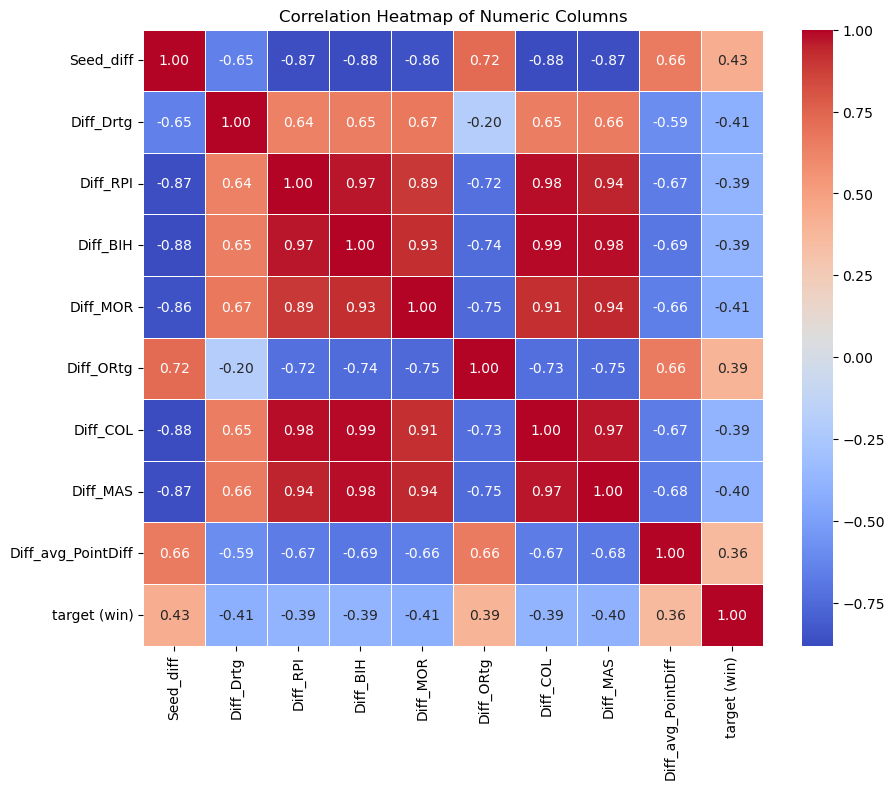

In [1179]:
numeric_df = X_train_selected_df.select_dtypes(include=['number'])
numeric_with_target = numeric_df.copy()
numeric_with_target['target (win)'] = y_train.values  # Or just y_train if it's already aligned

# Now compute the correlation matrix including the target
corr_matrix = numeric_with_target.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Numeric Columns")
plt.show()


Exporting full datasets:

In [1170]:
X_train.to_csv("train_test_split/X_train.csv", index = False)
X_test.to_csv("train_test_split/X_test.csv", index = False)
X_val.to_csv("train_test_split/X_validation.csv", index = False)

Exporting dataset labels (for reduced and full datasets:)

In [1171]:
y_train.to_csv("train_test_split/y_train.csv", index = False)
y_val.to_csv("train_test_split/y_validation.csv", index = False)
# y_test.to_csv() #don't have y test yet because we don't have the labels for 2025 yet (we have attributes - which teams played)

# Extra Testing (Variable Selection) below, Don't need

### Selection Using LASSO

In [1172]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import pandas as pd
lasso = Pipeline([
    ("scaler", StandardScaler()),  # Standardize the data
    ("lasso", Lasso(alpha=0.02, random_state=42))  # Lasso with regularization strength alpha
])
lasso.fit(X_train, y_train)

# coefficients selected by lasso 
lasso_coefficients = lasso.named_steps["lasso"].coef_

# get features and thier coefficients
lasso_feature_importance = pd.DataFrame({
    "Feature": X_train.columns,
    "Coefficient": lasso_coefficients
}).sort_values(by="Coefficient", ascending=False)

# see what features did not have coefficients of 0
selected_features = lasso_feature_importance[lasso_feature_importance["Coefficient"] != 0]
print(selected_features)

         Feature  Coefficient
19     Diff_ORtg     0.147315
34  Diff_avg_FGA     0.011297
3    Diff_avg_OR     0.003180
31  Diff_avg_Ast    -0.005496
23   Diff_avg_DR    -0.009349
1      Diff_Drtg    -0.155985


Increase alpha to get more variables that have nonzero coefficients

### Selection Using Recursive Feature Elimination

In [1173]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

model = LinearRegression()
rfe = RFE(estimator=model, n_features_to_select=10)  # Select top 10 features
rfe.fit(X_train, y_train)

# Get selected features
selected_features = X_train.columns[rfe.support_]
print("Selected features:", selected_features)

Selected features: Index(['Diff_Drtg', 'Diff_avg_PF', 'Diff_avg_Score', 'Diff_avg_opponent_FGM',
       'Diff_ORtg', 'Diff_avg_opponent_FTM', 'Diff_avg_opponent_FGM3',
       'Diff_avg_Ast', 'Diff_avg_Stl', 'Diff_avg_PointDiff'],
      dtype='object')


In [1174]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10)  # Reduce to 10 components
X_train_pca = pca.fit_transform(X_train)

# Explained variance ratio
print("Explained variance ratio:", pca.explained_variance_ratio_)

# likely not use PCA bc much harder to interpret in context because projecting data into desired dimension !!!

Explained variance ratio: [0.93714865 0.02890423 0.0083289  0.00823594 0.00344073 0.00308024
 0.00229241 0.00183365 0.00141138 0.00112812]


Also try mutual information, tree based feature selection, PCA, and variance threshold

# Need to get Xtest by finding which teams are playing 2025 Tourney 
## Use seeds and slots

In [1175]:
slots_2025 = slots[slots["Season"] == 2025]
slots_2025

,Season,Slot,StrongSeed,WeakSeed
2519,2025,R1W1,W01,W16
2520,2025,R1W2,W02,W15
2521,2025,R1W3,W03,W14
2522,2025,R1W4,W04,W13
2523,2025,R1W5,W05,W12
...,...,...,...,...
2581,2025,R6CH,R5WX,R5YZ
2582,2025,W16,W16a,W16b
2583,2025,X11,X11a,X11b
2584,2025,Y11,Y11a,Y11b


In [1176]:
seeds_2025 = seeds[seeds["Season"] == 2025]
# drop season because redundant info if all 2025
seeds_2025 = seeds2025[["Seed", "TeamID"]]
seeds_2025

,Seed,TeamID
1404,W01,1181
1405,W02,1104
1406,W03,1458
1407,W04,1112
1408,W05,1332
...,...,...
1467,Z12,1161
1468,Z13,1213
1469,Z14,1423
1470,Z15,1303


In [1177]:
seed_to_team = dict(zip(seeds_2025['Seed'], seeds_2025['TeamID']))

# Filter matchups with real seeds (not 'R1W1', 'X11a', etc.)
valid_slots = slots_2025[
    (slots_2025['StrongSeed'].isin(seed_to_team)) &
    (slots_2025['WeakSeed'].isin(seed_to_team))
].copy()

# Add Team1 and Team2 based on seeds
valid_slots['Team1'] = valid_slots['StrongSeed'].map(seed_to_team)
valid_slots['Team2'] = valid_slots['WeakSeed'].map(seed_to_team)

# Final test matchup DataFrame
test_matchups = valid_slots[['Team1', 'Team2']]
test_matchups['Season'] = 2025

# Apply your feature engineering method to generate X_test
#X_test = test_matchups.apply(lambda row: create_features(row['Team1'], row['Team2'], 2025), axis=1)


/var/folders/yz/btvl331d4g54624wdzgx_2hc0000gn/T/ipykernel_68530/351447197.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_matchups['Season'] = 2025


In [1178]:
test_matchups

,Team1,Team2,Season
2520,1104,1352,2025
2521,1458,1285,2025
2522,1112,1103,2025
2523,1332,1251,2025
2524,1140,1433,2025
2525,1388,1435,2025
2526,1280,1124,2025
2527,1222,1188,2025
2528,1397,1459,2025
2529,1246,1407,2025
